In [27]:
from __future__ import print_function
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import GenericUnivariateSelect

import xgboost as xgb

from __future__ import print_function 
import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange, tqdm
import pickle

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from hackathon.utils.utils import *
from hackathon.utils.draw_utils import *


In [9]:
test_data = parse_data("../data/test_data.csv")
train_data = parse_data("../data/train_data.csv")

In [10]:
train_data.shape, test_data.shape

((55375, 59), (4344, 59))

In [11]:
for i, c in enumerate(train_data.columns):
    print(i, c)

0 NPWD2372
1 NPWD2401
2 NPWD2402
3 NPWD2451
4 NPWD2471
5 NPWD2472
6 NPWD2481
7 NPWD2482
8 NPWD2491
9 NPWD2501
10 NPWD2531
11 NPWD2532
12 NPWD2551
13 NPWD2552
14 NPWD2561
15 NPWD2562
16 NPWD2691
17 NPWD2692
18 NPWD2721
19 NPWD2722
20 NPWD2742
21 NPWD2771
22 NPWD2791
23 NPWD2792
24 NPWD2801
25 NPWD2802
26 NPWD2821
27 NPWD2851
28 NPWD2852
29 NPWD2871
30 NPWD2872
31 NPWD2881
32 NPWD2882
33 sunmars_km
34 earthmars_km
35 sunmarsearthangle_deg
36 solarconstantmars
37 eclipseduration_min
38 occultationduration_min
39 sa
40 sx
41 sy
42 sz
43 dmop_count_24h_AAAA
44 dmop_count_24h_AACF
45 dmop_count_24h_ADMC
46 dmop_count_24h_AHHH
47 dmop_count_24h_AMMM
48 dmop_count_24h_AOOO
49 dmop_count_24h_APSF
50 dmop_count_24h_APWF
51 dmop_count_24h_ASEQ
52 dmop_count_24h_ASSS
53 dmop_count_24h_ASXX
54 dmop_count_24h_ATMB
55 dmop_count_24h_ATTT
56 dmop_count_24h_AVVV
57 dmop_count_24h_AXXX
58 dmop_count_24h_sum


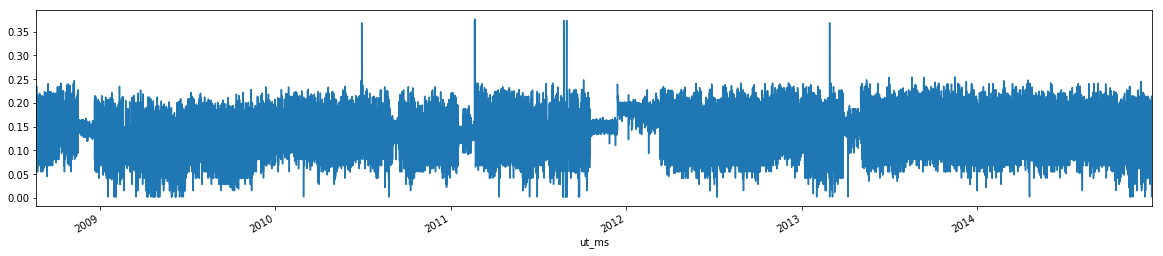

In [12]:
train_data.NPWD2372.plot(figsize=(20, 4))

In [13]:
train_dates = train_data.index < '2014-08-01 00:00:00'

In [14]:
train_df = train_data[train_dates]
valid_df = train_data[~train_dates]

train_df.shape, valid_df.shape

((51741, 59), (3634, 59))

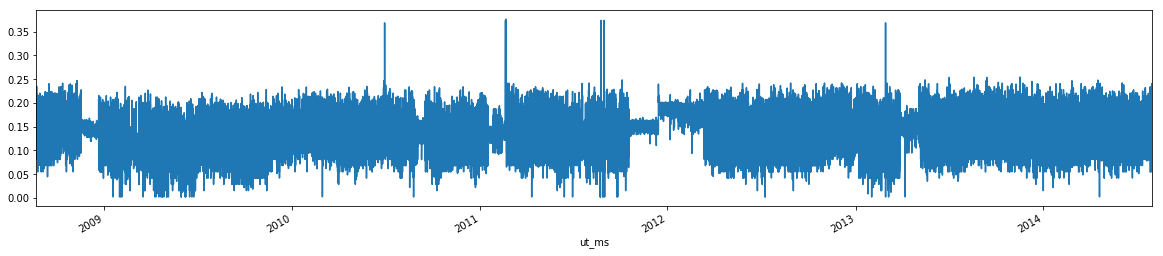

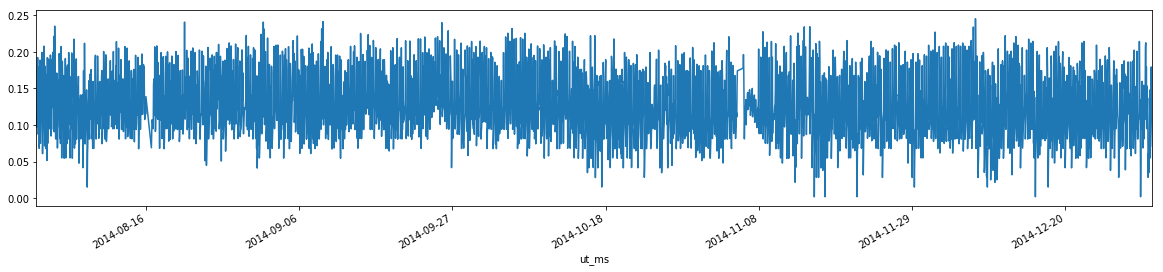

In [15]:
train_df.NPWD2372.plot(figsize=(20, 4))
plt.show()
valid_df.NPWD2372.plot(figsize=(20, 4))

In [16]:
y_columns = filter(lambda x: "NPWD"  in x, train_df.columns)
y_columns

['NPWD2372',
 'NPWD2401',
 'NPWD2402',
 'NPWD2451',
 'NPWD2471',
 'NPWD2472',
 'NPWD2481',
 'NPWD2482',
 'NPWD2491',
 'NPWD2501',
 'NPWD2531',
 'NPWD2532',
 'NPWD2551',
 'NPWD2552',
 'NPWD2561',
 'NPWD2562',
 'NPWD2691',
 'NPWD2692',
 'NPWD2721',
 'NPWD2722',
 'NPWD2742',
 'NPWD2771',
 'NPWD2791',
 'NPWD2792',
 'NPWD2801',
 'NPWD2802',
 'NPWD2821',
 'NPWD2851',
 'NPWD2852',
 'NPWD2871',
 'NPWD2872',
 'NPWD2881',
 'NPWD2882']

In [17]:
x_columns = filter(lambda x: "NPWD" not in x 
                   and 'ut_ms' not in x, train_df.columns)
x_columns

['sunmars_km',
 'earthmars_km',
 'sunmarsearthangle_deg',
 'solarconstantmars',
 'eclipseduration_min',
 'occultationduration_min',
 'sa',
 'sx',
 'sy',
 'sz',
 'dmop_count_24h_AAAA',
 'dmop_count_24h_AACF',
 'dmop_count_24h_ADMC',
 'dmop_count_24h_AHHH',
 'dmop_count_24h_AMMM',
 'dmop_count_24h_AOOO',
 'dmop_count_24h_APSF',
 'dmop_count_24h_APWF',
 'dmop_count_24h_ASEQ',
 'dmop_count_24h_ASSS',
 'dmop_count_24h_ASXX',
 'dmop_count_24h_ATMB',
 'dmop_count_24h_ATTT',
 'dmop_count_24h_AVVV',
 'dmop_count_24h_AXXX',
 'dmop_count_24h_sum']

In [18]:
# create train/valid datasets
X_train = train_df[x_columns]
y_train = train_df[y_columns]

X_valid = valid_df[x_columns]
y_valid = valid_df[y_columns]

X_test = test_data[x_columns]

In [69]:
parameter_dict = {
    "n_estimators":200,
    "silent":1,
    "nthread":-1,
    "gamma":0.001,
    "max_depth":6,
    "min_child_weight":2,
    "max_delta_step":1,
    "subsample":1,
    "reg_lambda":0.1,
    "reg_alpha":0.1,
}

xgb_model =xgb.XGBRegressor(**parameter_dict)
reg = MultiOutputRegressor(estimator=xgb_model)

In [70]:
reg.fit(X_train, y_train)

predicts = reg.predict(X_valid)

loss = sum(mean_squared_error(y_valid,predicts, multioutput='raw_values'))
print("Loss is:",loss)

Loss is: 0.248939368028


In [71]:
y_train.shape

(51741, 33)

In [72]:
X_train.shape

(51741, 26)

In [73]:
models_dict = {}

for name in y_columns:
    xgb_handler = xgb.XGBRegressor(**parameter_dict)
    models_dict[name] = xgb_handler

In [74]:
models_dict

{'NPWD2372': XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
        gamma=0.001, learning_rate=0.1, max_delta_step=1, max_depth=6,
        min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
        objective='reg:linear', reg_alpha=0.1, reg_lambda=0.1,
        scale_pos_weight=1, seed=0, silent=1, subsample=1),
 'NPWD2401': XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
        gamma=0.001, learning_rate=0.1, max_delta_step=1, max_depth=6,
        min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
        objective='reg:linear', reg_alpha=0.1, reg_lambda=0.1,
        scale_pos_weight=1, seed=0, silent=1, subsample=1),
 'NPWD2402': XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
        gamma=0.001, learning_rate=0.1, max_delta_step=1, max_depth=6,
        min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
        objective='reg:linear', reg_alpha=0.1, reg_lambda=0.1,
        scale

In [79]:
#y_train = y_train.as_matrix()
for name, data in zip(y_columns, xrange(y_train.shape[1])):
    print("Fitting model", name)
    y_data = y_train[:,data]
    models_dict[name].fit(X_train, y_data)

Fitting model NPWD2372
Fitting model NPWD2401
Fitting model NPWD2402
Fitting model NPWD2451
Fitting model NPWD2471
Fitting model NPWD2472
Fitting model NPWD2481
Fitting model NPWD2482
Fitting model NPWD2491
Fitting model NPWD2501
Fitting model NPWD2531
Fitting model NPWD2532
Fitting model NPWD2551
Fitting model NPWD2552
Fitting model NPWD2561
Fitting model NPWD2562
Fitting model NPWD2691
Fitting model NPWD2692
Fitting model NPWD2721
Fitting model NPWD2722
Fitting model NPWD2742
Fitting model NPWD2771
Fitting model NPWD2791
Fitting model NPWD2792
Fitting model NPWD2801
Fitting model NPWD2802
Fitting model NPWD2821
Fitting model NPWD2851
Fitting model NPWD2852
Fitting model NPWD2871
Fitting model NPWD2872
Fitting model NPWD2881
Fitting model NPWD2882


In [80]:
names = models_dict.keys
#y_valid = y_valid.as_matrix()

In [81]:
names()

['NPWD2501',
 'NPWD2742',
 'NPWD2481',
 'NPWD2871',
 'NPWD2872',
 'NPWD2482',
 'NPWD2852',
 'NPWD2851',
 'NPWD2882',
 'NPWD2451',
 'NPWD2531',
 'NPWD2532',
 'NPWD2552',
 'NPWD2551',
 'NPWD2771',
 'NPWD2801',
 'NPWD2802',
 'NPWD2791',
 'NPWD2821',
 'NPWD2792',
 'NPWD2881',
 'NPWD2491',
 'NPWD2372',
 'NPWD2471',
 'NPWD2562',
 'NPWD2691',
 'NPWD2692',
 'NPWD2561',
 'NPWD2472',
 'NPWD2401',
 'NPWD2402',
 'NPWD2721',
 'NPWD2722']

In [82]:
total_loss = []
for i, name in enumerate(names()):
    print("Loss of",name)
    predicts = models_dict[name].predict(X_valid)
    loss = mean_squared_error(y_valid[:,i], predicts)
    total_loss.append(loss)

Loss of NPWD2501
Loss of NPWD2742
Loss of NPWD2481
Loss of NPWD2871
Loss of NPWD2872
Loss of NPWD2482
Loss of NPWD2852
Loss of NPWD2851
Loss of NPWD2882
Loss of NPWD2451
Loss of NPWD2531
Loss of NPWD2532
Loss of NPWD2552
Loss of NPWD2551
Loss of NPWD2771
Loss of NPWD2801
Loss of NPWD2802
Loss of NPWD2791
Loss of NPWD2821
Loss of NPWD2792
Loss of NPWD2881
Loss of NPWD2491
Loss of NPWD2372
Loss of NPWD2471
Loss of NPWD2562
Loss of NPWD2691
Loss of NPWD2692
Loss of NPWD2561
Loss of NPWD2472
Loss of NPWD2401
Loss of NPWD2402
Loss of NPWD2721
Loss of NPWD2722


In [53]:
total_loss

[0.015935389281121103,
 4.91940811240768e-05,
 0.029952670396082168,
 0.2044884386565203,
 6.2120917197752228e-10,
 3.5177379607476981e-07,
 8.7510318616650068e-10,
 0.074749668949751227,
 0.034552108003727419,
 0.20662994907143917,
 0.00040634499721429107,
 0.10497188573239886,
 0.14366977328707142,
 0.079275272020759138,
 0.020263814905076054,
 0.17189909879343376,
 0.010732850307171572,
 0.0087101384774666904,
 0.014717430973769449,
 0.027146247775715022,
 0.0016260620790138796,
 0.001258080800915146,
 0.0076890767950406422,
 3.5021711278006719e-07,
 0.17310811021643471,
 0.012132392045364778,
 2.707013546756675e-05,
 0.030403319091926104,
 0.0012274829994667034,
 0.00090732040246998451,
 0.030487617088785966,
 0.011459916015052559,
 0.028507550830904303]

In [54]:
print("Total loss:",sum(total_loss))

Total loss: 1.4469849777


In [59]:
y_train.dtype

dtype('float64')

In [65]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [67]:
y_train.shape

(51741, 33)

In [85]:
X_list = []
for i in xrange(y_train.shape[1]):
    X_new = SelectKBest(score_func=f_regression,k=15).fit_transform(X_train, y_train[:,i])
    X_list.append(X_new)

In [89]:
for x in X_list:
    print(x.shape)

(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
(51741, 15)
